# Can an LLM tell real from artificial poetry?

In [87]:
import os
import random
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import NormalDist
from sklearn.metrics import confusion_matrix, f1_score
from openai import OpenAI
from tqdm import tqdm

Non poco si è scritto sulle capacità degli LLM di generare letteratura. Non molta attenzione è stata invece dedicata alla domanda: un LLM può distinguere una poesia da dei versi generati artificialmente? Questo notebook tenta di rispondere a questa domanda. Per farlo, propongo un semplice compito di classificazione, in cui più LLM classificano un insieme di testi come “poesie” o “non poesie”.
Prendiamo un campione di $n > 96$ poesie dove 
$$n = \frac{Z^2\cdot{p}\cdot(1-p)}{E^2}$$
con:
- $Z$ = Z-score per un livello di confidenza del 95%
- $p$ = proporzione di esempi positivi = 50%
- $E$ = margine di errore pari a 0.10.

Le poesie sono state selezionate da un campione relativamente arbitrario di poeti elencati nella categoria Wikipedia [_Poeti italiani del XXI secolo_](https://it.wikipedia.org/wiki/Categoria:Poeti_italiani_del_XXI_secolo). Più o meno, ho inserito autori a me noti o che comunque ritenevo "noti" se non al grande pubblico a un pubblico non limitato agli addetti ai lavori. Di seguito 

In [31]:
with open("out/poems.json", "r") as f:
    poems = json.loads(f.read())["poems"]
df = pd.DataFrame(poems)
df = df.set_index("id", drop=True)
df["author"] = df["first_name"] + " " + df["last_name"]
df = df.drop(["first_name", "last_name"], axis=1)
authors = df.author.unique()
print("Totale poesie: {}".format(len(df)))
print("-"*25)
print("Numero autori inclusi: {}".format(len(authors)))
print("-"*25)
print(f"Autori inclusi:")
for author in authors:
    print("  {}".format(author))


Totale poesie: 105
-------------------------
Numero autori inclusi: 19
-------------------------
Autori inclusi:
  Sandro Penna
  Attilio Bertolucci
  Edoardo Sanguineti
  Cristina Campo
  Vittorio Sereni
  Patrizia Cavalli
  Mariangela Gualtieri
  Gilda Policastro
  Nanni Balestrini
  Luciano Erba
  Umberto Fiori
  Milo De Angelis
  Valentino Zeichen
  Michele Mari
  Maurizio Cucchi
  Andrea Zanzotto
  Dario Bellezza
  Giorgio Caproni
  Giovanna Bemporad


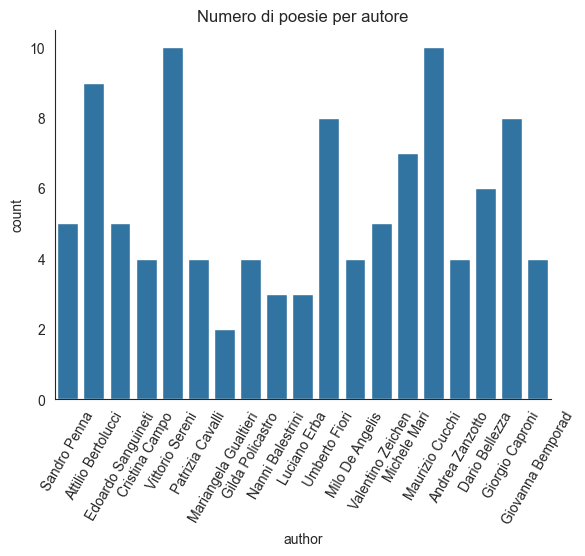

In [32]:
sns.set_style('white')
sns.countplot(df,x="author")
plt.xticks(rotation=60)
plt.title("Numero di poesie per autore")
sns.despine()
plt.show()

In [33]:
df["length"] = df["text"].apply(len)

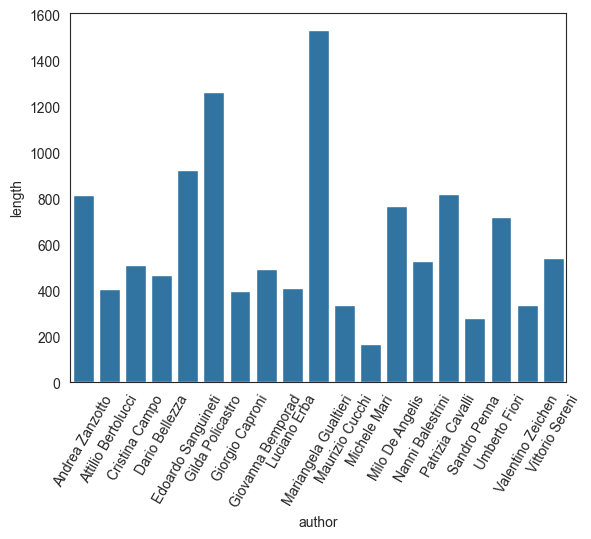

In [34]:
sns.barplot(x="author", y="length", data=df.drop(["title", "text"], axis=1).groupby("author").mean())
plt.xticks(rotation=60)
plt.show()

In [35]:
def num_verses(poem):
    return poem.count("\n")

df["num_verses"] = df["text"].apply(lambda poem: num_verses(poem))
verse_len_stats = df.drop(["title", "text"], axis=1).groupby("author").mean()["num_verses"].describe()
verse_len_stats

count    19.000000
mean     15.998454
std       8.453505
min       4.700000
25%      12.000000
50%      13.666667
75%      16.775000
max      35.500000
Name: num_verses, dtype: float64

In [36]:
df.head()

,title,text,author,length,num_verses
id,,,,,
0,Le nere scale della mia taverna,Le nere scale della mia taverna\ntu discendi t...,Sandro Penna,269,8
1,"Era l’alba su i colli, e gli animali","Era l’alba su i colli, e gli animali\nridavano...",Sandro Penna,460,12
2,Quando tornai al mare di una volta,"Quando tornai al mare di una volta,\nnella ser...",Sandro Penna,306,8
3,Ero solo e seduto. La mia storia,Ero solo e seduto. La mia storia\nappoggiavo a...,Sandro Penna,282,7
4,Felice chi è diverso,Felice chi è diverso\nessendo egli diverso.\nM...,Sandro Penna,87,3


In [37]:
client = OpenAI()

In [38]:
texts_for_topics = "\n***\n".join(list(df.text.values))

In [42]:
themes = client.chat.completions.create(
  model="gpt-4o",
  messages=[
    {"role": "system", "content": "Ti verrà fornita una lista di poemi separati da '\n***\n'. Il tuo compito è identificare una dozzina di temi ricorrenti. Rispondi con un semplice elenco di temi e parole chiave, senza commenti o spiegazioni. Non aggiungere nulla."},
    {"role": "user", "content": texts_for_topics}
  ]
)

themes = themes.choices[0].message.content
print(themes)

1. Natura: vento, mare, fiume, animali, piante.
2. Memoria e nostalgia: ritorno, passato, ricordi, malinconia.
3. Amore e desolazione: amore, solitudine, dolore, addio.
4. Tempi e passaggi: stagione, autunno, primavera, notte, giorno.
5. Paesaggi urbani e ruralità: città, casa, collina, porto, taverna.
6. Giovinezza e vecchiaia: giovinezza, vecchiaia, tempi della vita.
7. Povertà ed emarginazione: disoccupazione, precarietà, povertà, emarginazione.
8. Misteri e spiritualità: chiesa, preghiera, speranza, silenzio.
9. Politica e società: politica, guerra, diversità, odio.
10. Arte e creazione: poesia, parole, arte, creatività.
11. Identità e alterità: diverso, identità, cambiamento, essere.
12. Destino e morte: morte, destino, passaggio, eternità.


In [43]:
def create_poems():
    out = client.chat.completions.create(
      model="gpt-4o",
      messages=[
    {"role": "system", "content": "Sei un poeta italiano che scrive nel periodo 1960-2020. Il tuo compito è scrivere poesie"},
    {"role": "user", "content": f"Genera 10 poesie sui seguenti temi e parole chiave: {themes}. Le poesie devono essere lunghe da 5 a 35 versi con una media di 16 versi. Rispondi con un elenco di poesie separate da '***' senza commenti o spiegazioni. IMPORTANTE: assicurati di non aggiungere nulla se non i testi delle poesie e il separatore. Non aggiungere i temi e le parole chiave all'output."}
  ]
)

    return out.choices[0].message.content

In [44]:
artificial_poems = ""
for _ in range(10):
    artificial_poems += create_poems()

In [45]:
with open("texts/artificial_poems.txt", "w") as f:
    f.write(artificial_poems)

In [46]:
with open("texts/artificial_poems.txt") as f:
    artificial_poems = f.read()

In [94]:
real_poems_list = list(df.text.values)
artificial_poems_list = [poem.strip() for poem in artificial_poems.split("***")]
print(len(artificial_poems_list), len(real_poems_list))
artificial_poems_list = artificial_poems_list[:len(real_poems_list)]
print(len(artificial_poems_list), len(real_poems_list))

124 105
105 105


In [95]:
real_poems_for_pd = [{"text": poem, "label": 1} for poem in real_poems_list]
all_poems_for_pd = real_poems_for_pd + [{"text": poem, "label": 0} for poem in artificial_poems_list]

In [123]:
test_df = pd.DataFrame(all_poems_for_pd)

In [124]:
# Shuffling the text column
shuffled_df = test_df.sample(frac=1).reset_index(drop=True)
print(len(shuffled_df))

210


In [125]:
def get_predictions(texts):
    predictions = []
    for text in texts:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a text classification model."},
                {"role": "user", "content": f"Classify the following text into 1 or 0 where 1 is a poem written by a human, a recognized poet, and 0 is an artificially generated poem:\n\n{text}. Do not comment. Just output 1 or 0"}
            ]
        )
        prediction = int(response.choices[0].message.content.strip())
        predictions.append(prediction)
    return predictions

In [126]:
def plot_confusion_matrix():
    # Calculate and display the final confusion matrix for the last trial
    conf_matrix = confusion_matrix(shuffled_df['label'], shuffled_df['predicted_label'])
    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [132]:
def run_trials(num_trials, variance_threshold, plot_confusion_matrix=False):

    # Variables to store results
    accuracies = []
    f1_scores = []
    
    while True:
        for trial in tqdm(range(1, num_trials+1)):
            print("Trial: " + str(trial))
            
            # Get predictions for the shuffled texts
            predictions = get_predictions(shuffled_df['text'].tolist())
            
            # Add the predictions to the DataFrame
            shuffled_df['predicted_label'] = predictions
            
            # Calculate accuracy and F1-score
            accuracy = (shuffled_df['label'] == shuffled_df['predicted_label']).mean()
            f1 = f1_score(shuffled_df['label'], shuffled_df['predicted_label'], average='weighted')
            print(f"Accuracy: {accuracy}, F1: {f1}")
            # Append to results
            accuracies.append(accuracy)
            f1_scores.append(f1)
            if plot_confusion_matrix:
                plot_confusion_matrix()
        
        # Calculate mean and standard deviation
        mean_accuracy = np.mean(accuracies)
        std_accuracy = np.std(accuracies)
        mean_f1 = np.mean(f1_scores)
        std_f1 = np.std(f1_scores)    
        # Check if variance is acceptable
        if std_accuracy**2 <= variance_threshold: #and std_f1**2 <= variance_threshold:
            break
        else:
            trials += 2  # Increment the number of trials
    
    # Print final results
    print("FINAL RESULTS")
    print("="*50)
    print(f"Mean Accuracy: {mean_accuracy}, Standard Deviation: {std_accuracy}")
    print(f"Mean F1 Score: {mean_f1}, Standard Deviation: {std_f1}")
    print(f"Total trials: {num_trials}")
    return accuracies, f1_scores

In [133]:
variance_threshold = 0.04
num_trials = 5
run_trials(num_trials, variance_threshold, plot_confusion_matrix=True)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

Trial: 1


  0%|                                                     | 0/5 [00:19<?, ?it/s]


ValueError: invalid literal for int() with base 10: 'I need the text to make a classification. Please provide the text you want classified.'